## Previously defined functions

In [1]:
## Here is the likelihood function for a Logit
calcllik<-function(b,data){           
  y<-data[,1]
  x<-data[,2]

  pi<- 1/(1+exp(-b[1] - b[2]*x))        # Here is the systematic component
  llik<-y * log(pi) + (1-y) * log(1-pi) # Here is the stocastic component
    
  return(-llik)
}

## Differentially private mean release
gaussianReleaseNoise <- function(size=1, sensitivity, epsilon, delta){
	scale <- sensitivity *log(1.25/delta)/ epsilon
	noise <- rnorm(n=size, mean=0, sd=scale)
	return(noise)
}

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Run with actual data

In [2]:
library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")     


mydata<-PUMSdata[c("married","educ")]

#predict are you married {0,1} based on education
output <- glm(married ~ educ, family="binomial", data=mydata)

print(summary(output))


Call:
glm(formula = married ~ educ, family = "binomial", data = mydata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4551  -1.2135   0.9831   1.0769   1.4144  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.619976   0.015070  -41.14   <2e-16 ***
educ         0.078282   0.001404   55.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 333086  on 241829  degrees of freedom
Residual deviance: 329918  on 241828  degrees of freedom
AIC: 329922

Number of Fisher Scoring iterations: 4



## Show the estimated model

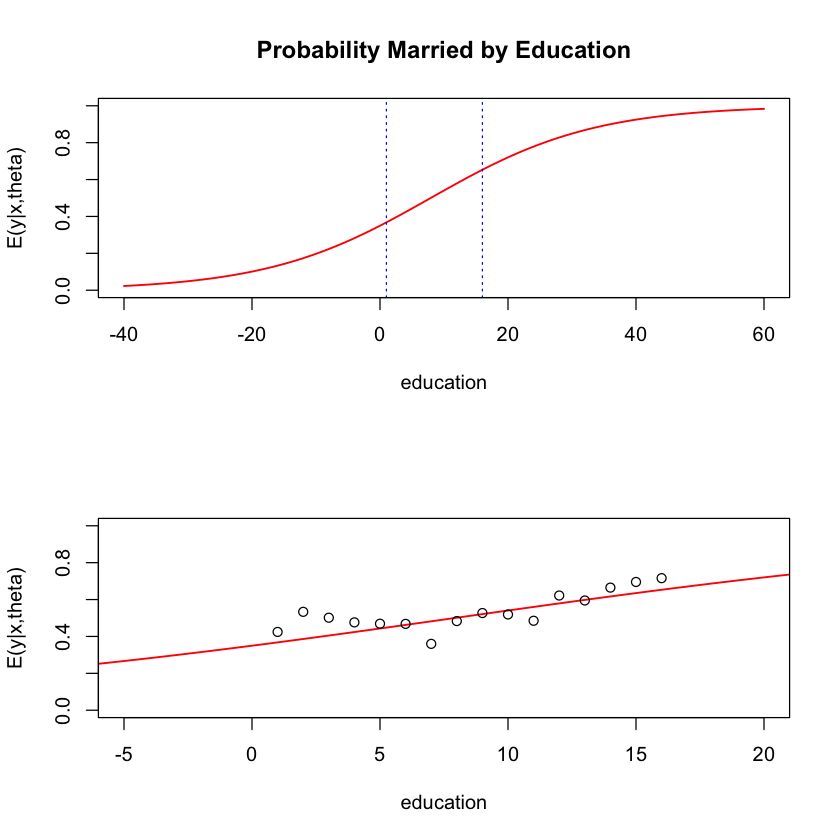

In [3]:
xseq <- seq(from=-40, to=60, length=100)
f <- 1/(1 + exp(-output$coef[1] -output$coef[2]*xseq))

par(mfcol=c(2,1))

plot(xseq, f, type="l", lwd=1.5, col="red", ylim=c(0,1), ylab="E(y|x,theta)", xlab="education", main="Probability Married by Education")
abline(v=1, col="blue", lty=3)
abline(v=16, col="blue", lty=3)

plot(xseq, f, type="l", lwd=1.5, col="red", ylim=c(0,1), ylab="E(y|x,theta)", xlab="education", xlim=c(-5,20))
for(i in 1:16){
	flag<-mydata$educ==i
	points(x=i, y=mean(mydata[flag,"married"]))
}


## Show the LogLikelihood surface

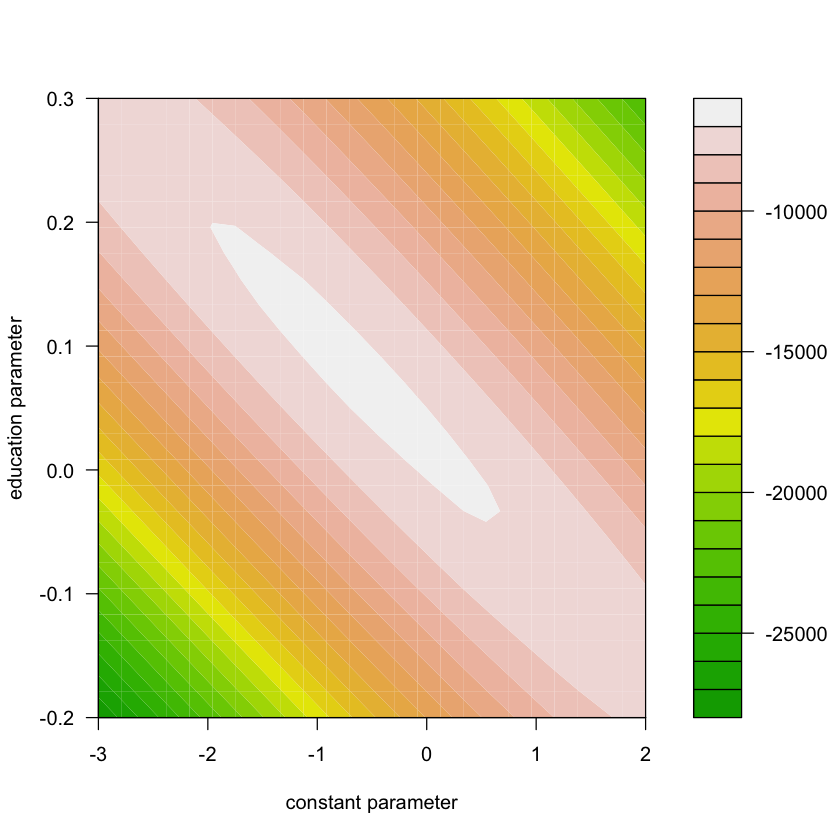

In [4]:
sample.data <- mydata[sample(1:nrow(mydata),10000), ]
b1.seq <- seq(from=-3, to=2, length=25)
b2.seq <- seq(from=-.2, to=.3, length=25)
llsurface <- matrix(NA, nrow=length(b1.seq), ncol=length(b2.seq))

for(i in 1:length(b1.seq)){
	for(j in 1:length(b2.seq)){
		llsurface[i,j] <- sum(-1* calcllik(b=c(b1.seq[i], b2.seq[j]), data=sample.data) )
	}
}

filled.contour(x=b1.seq, y=b2.seq, z=llsurface, color = terrain.colors,  xlab="constant parameter", ylab="education parameter")





$\beta_0$ shifts the center of the sigmoid left and right. $\beta_1$ stretches the sigmoid.

Adjust step size by gradually making it smaller, adjusting step size based on second derivative, or stopping if we keep oscillating between two points.

## Stocastic Gradient Descent

pdf 
  2

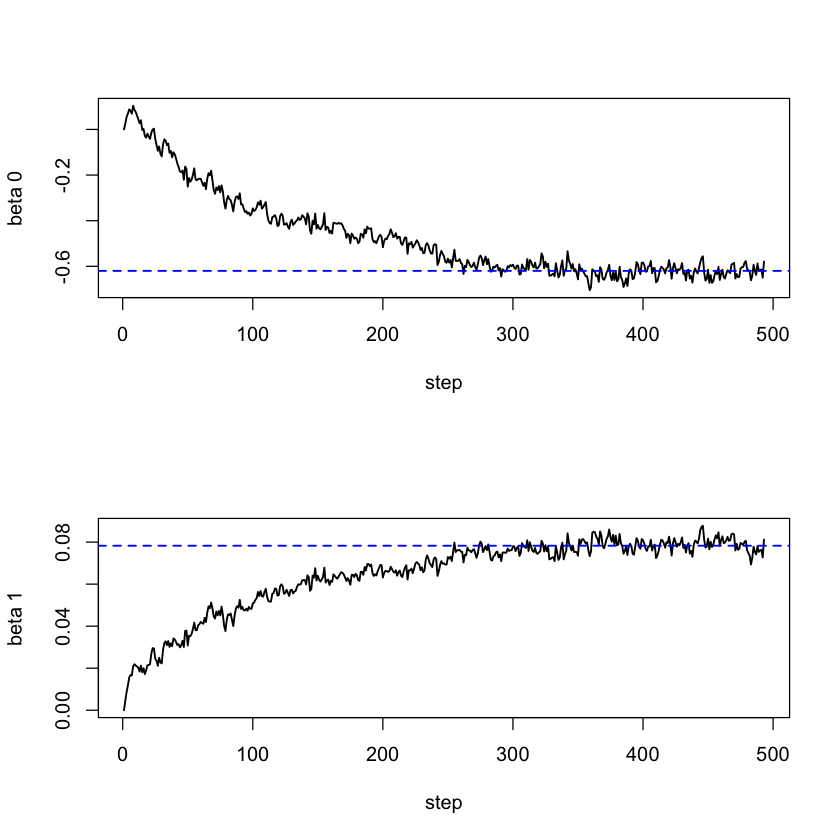

In [13]:
# Calculate the gradient at a point in the parameter space
calcgradient <- function(B, C, theta, fun){
	dx <- 0.0001
    #using numerical approximation of gradient for each theta. Assuming two thetas
	out1 <-	eval(fun(b=theta, data=B))
	out2 <- eval(fun(b=theta + c(0,dx), data=B))
	out3 <- eval(fun(b=theta + c(dx,0), data=B))

	Del.1 <- (out3 - out1) / dx;
	Del.1 <- clip(Del.1, lower=-C, upper=C);
	mean.Del.1 <- mean(Del.1)

	Del.2 <- (out2 - out1) / dx;                          # Fix this
	Del.2 <- clip(Del.2, lower=-C, upper=C)  # Fix this
	mean.Del.2 <- mean(Del.2)

	return(c(mean.Del.1,mean.Del.2))
}



N <- nrow(mydata);
L <- round(sqrt(nrow(mydata)));     # This is the recommended batch size- sqrt(# of training examples)

steps <- L;   	  # Fix this

## Shuffle the data
index <- sample(1:nrow(mydata)); #shuffle because we worry the data may have been sorted in some way
mydata <- mydata[index,];
epsilon <-1;

theta <- c(0,0)   # Starting parameters
C <- 10			  # Interval to clip over
nu <- c(1,0.01)   # Learning speeds


history <- matrix(NA, nrow=steps+1, ncol=2)
history[1,] <- theta


# Iterate one step of SGD
for(i in 1:steps){
	startB <- ((i-1)*L+1) #beginning index for our batch
	if(i<L){
		stopB <- i*L
	}else{
		stopB <- nrow(mydata)
	}

# 	index<-sample(1:nrow(mydata),L)
	B <- mydata[startB:stopB, ]; #get rows for this batch
    
    #get gradient for each parameter and add Gaussian noise to each
    #B is the data. Theta is current values for the parameters. 
    #calcllik is the function we want to calculate the gradient for.
    #epsilon can be multiplied by L because we're only using L rows from the data, so this is functionally equal to using epsilon
	Del <- calcgradient(B, C, theta, fun=calcllik) + gaussianReleaseNoise(size=2, sensitivity= 2*C/L, 
                                                                          epsilon=epsilon/2*L, delta=1e-5);
    #epsilon/2 * L
# 	cat("Del:  ",Del,"\n")
	theta <- theta - nu*Del;   #theta^(l+1) = theta^(l) - learningRate * gradient
# 	cat("Theta:",theta, "\n")

	history[i+1,] <- theta

}

par(mfcol=c(2,1))

all.ylim<-c( min(c(history[,1],output$coef[1] )), max(c(history[,1],output$coef[1] )))
plot(history[,1], type="l", ylim=all.ylim, ylab="beta 0", xlab="step", lwd=1.5)
abline(h=output$coef[1], lty=2, col="blue", lwd=1.5)


all.ylim<-c( min(c(history[,2],output$coef[2] )), max(c(history[,2],output$coef[2] )))
plot(history[,2], type="l", ylim=all.ylim, ylab="beta 1", xlab="step", lwd=1.5)
abline(h=output$coef[2], lty=2, col="blue", lwd=1.5)

dev.copy2pdf(file="./figs/dpSGD.pdf")



Jitteriness comes from sampling error, not from us jumping around the point.